# Neural Networks for Classifications

In [1]:
import pandas as pd

In [2]:
pseudo_df = pd.read_csv("pseudo_data.csv")

In [3]:
def create_pres(row):
    if row['LOCATION_TYPE'] == 'presence':
        return 1
    else:
        return 0

In [4]:
pseudo_df['presence'] = pseudo_df.apply(create_pres, axis=1)

In [5]:
pseudo_df = pseudo_df.drop(columns="LOCATION_TYPE")

In [6]:
pseudo_df

,X,Y,presence
0,-52.380000,-32.210000,1
1,-52.310000,-31.560000,1
2,-55.630000,-30.800000,1
3,-51.320000,-30.370000,1
4,-54.370000,-30.340000,1
...,...,...,...
10052,-50.462647,0.687295,0
10053,-49.348610,-17.863429,0
10054,-65.143216,-6.485591,0
10055,-64.869285,-5.584057,0


# Train-Test Split

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

X = pseudo_df[["X", "Y"]].values.astype(np.float32)
y = pseudo_df["presence"].values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, random_state=42, stratify=y
)


train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_ds = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)


In [9]:
X_train

array([[-68.74632 ,   0.25827 ],
       [-53.51    , -20.58    ],
       [-51.      , -18.6     ],
       ...,
       [-49.896255, -19.087378],
       [-55.05193 ,  -7.195043],
       [-61.11    ,  -6.79    ]], dtype=float32)

# TRAINING A CLASSIC NEURAL NETWORK 

In [10]:
class VanillaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


# BINARY CROSS-ENTROPY LOSS

In [11]:
model = VanillaNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()  


# NN TRAIN

In [12]:

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

best_model_state = None

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    total_loss = 0

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(x_batch)
        loss = loss_fn(preds, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    
    model.eval()
    with torch.no_grad():
        val_preds = model(X_test_tensor)
        val_loss = loss_fn(val_preds, y_test_tensor.view(-1, 1)).item()
        val_binary_preds = (val_preds > 0.5).int().squeeze()
        val_acc = (val_binary_preds == y_test_tensor.int()).float().mean().item()

    print(f"Epoch {epoch+1} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

   
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break


if best_model_state:
    model.load_state_dict(best_model_state)


Epoch 1 | Train Loss: 69.6749 | Val Loss: 0.6758 | Val Acc: 0.5935
Epoch 2 | Train Loss: 64.6242 | Val Loss: 0.6786 | Val Acc: 0.5818
Epoch 3 | Train Loss: 64.3604 | Val Loss: 0.6740 | Val Acc: 0.5784
Epoch 4 | Train Loss: 63.7750 | Val Loss: 0.6558 | Val Acc: 0.6524
Epoch 5 | Train Loss: 63.3941 | Val Loss: 0.6866 | Val Acc: 0.5138
Epoch 6 | Train Loss: 62.8982 | Val Loss: 0.6213 | Val Acc: 0.7067
Epoch 7 | Train Loss: 59.9806 | Val Loss: 0.7386 | Val Acc: 0.6338
Epoch 8 | Train Loss: 56.0982 | Val Loss: 0.5471 | Val Acc: 0.6989
Epoch 9 | Train Loss: 49.1402 | Val Loss: 0.5498 | Val Acc: 0.7339
Epoch 10 | Train Loss: 46.1638 | Val Loss: 0.5156 | Val Acc: 0.7480
Epoch 11 | Train Loss: 46.5703 | Val Loss: 0.4736 | Val Acc: 0.7636
Epoch 12 | Train Loss: 45.7724 | Val Loss: 0.4468 | Val Acc: 0.7990
Epoch 13 | Train Loss: 46.0777 | Val Loss: 0.4858 | Val Acc: 0.7629
Epoch 14 | Train Loss: 44.5704 | Val Loss: 0.4388 | Val Acc: 0.8045
Epoch 15 | Train Loss: 42.6248 | Val Loss: 0.4402 | Val A

# evaluation

In [14]:

model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor)
    binary_preds = (test_preds > 0.5).int().squeeze()

from sklearn.metrics import classification_report

y_true = y_test_tensor.numpy()
y_pred = binary_preds.numpy()

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

         0.0       0.84      0.79      0.81      3500
         1.0       0.80      0.85      0.83      3540

    accuracy                           0.82      7040
   macro avg       0.82      0.82      0.82      7040
weighted avg       0.82      0.82      0.82      7040



In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Confusion Matrix:
[[2763  737]
 [ 533 3007]]
Accuracy:  0.8196
Precision: 0.8032
Recall:    0.8494
F1 Score:  0.8256


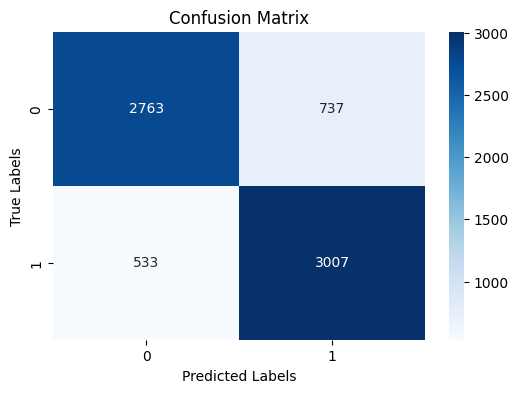

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Predictions Visualization

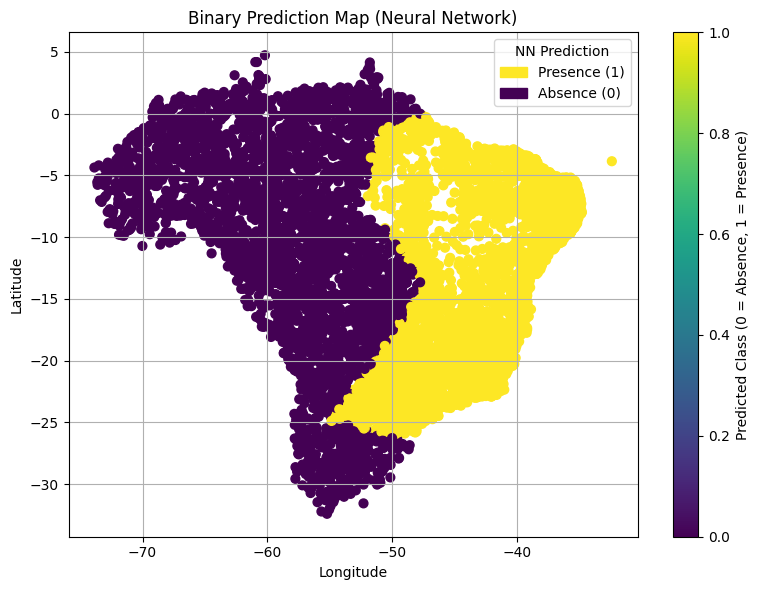

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
binary_preds_np = binary_preds.cpu().numpy()  

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_test[:, 0],           
    X_test[:, 1],           
    c=binary_preds_np,     
    cmap="viridis",
    s=40
)
presence_patch = mpatches.Patch(color=plt.cm.viridis(1.0), label="Presence (1)")
absence_patch  = mpatches.Patch(color=plt.cm.viridis(0.0), label="Absence (0)")

plt.legend(handles=[presence_patch, absence_patch], title="NN Prediction")
plt.colorbar(label="Predicted Class (0 = Absence, 1 = Presence)")
plt.title("Binary Prediction Map (Neural Network)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()


# NN WITH COVARIATES

In [33]:
! pip install geopandas


[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: C:\Users\dzaik\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [34]:
! pip install rioxarray


[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: C:\Users\dzaik\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [35]:
! pip install earthpy


[notice] A new release of pip available: 22.2.2 -> 25.1.1
[notice] To update, run: C:\Users\dzaik\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


In [19]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import rioxarray as rxr

import earthpy as et


sns.set(font_scale=1.5, style="white")

In [20]:
import rasterio

raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_water_occurrence.asc"
with rasterio.open(raster_path) as src:
    print(src.crs)


None


In [21]:
from rasterio.crs import CRS
from shapely.geometry import Point

gdf = gpd.GeoDataFrame(
    pseudo_df,
    geometry=gpd.points_from_xy(pseudo_df['X'], pseudo_df['Y']),
    crs="EPSG:4326"
)
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_water_occurrence.asc"
with rasterio.open(raster_path) as src:
    if src.crs is None:
        src_crs = CRS.from_epsg(4326)
    else:
        src_crs = src.crs
    
    # Extracting raster values at point coordinates
    coords = [(point.x, point.y) for point in gdf.geometry]
    values = [val[0] for val in src.sample(coords)]

gdf["water_occurrence"] = values

In [22]:
print("GeoDataFrame CRS:", gdf.crs)

#the dataset with extracted values
print(gdf[["X", "Y", "water_occurrence"]].shape)


GeoDataFrame CRS: EPSG:4326
(10057, 3)


In [23]:
gdf.head()

,X,Y,presence,geometry,water_occurrence
0,-52.38,-32.21,1,POINT (-52.38 -32.21),16.0
1,-52.31,-31.56,1,POINT (-52.31 -31.56),28.0
2,-55.63,-30.80,1,POINT (-55.63 -30.8),3.0
3,-51.32,-30.37,1,POINT (-51.32 -30.37),62.0
4,-54.37,-30.34,1,POINT (-54.37 -30.34),16.0


In [24]:
brazil_data_with_water = pd.DataFrame(gdf.drop(columns="geometry"))
print(brazil_data_with_water.head())

       X      Y  presence  water_occurrence
0 -52.38 -32.21         1              16.0
1 -52.31 -31.56         1              28.0
2 -55.63 -30.80         1               3.0
3 -51.32 -30.37         1              62.0
4 -54.37 -30.34         1              16.0


In [25]:
brazil_data_with_water.shape

(10057, 4)

In [26]:

gdf = gpd.GeoDataFrame(
    brazil_data_with_water,
    geometry=gpd.points_from_xy(brazil_data_with_water['X'], brazil_data_with_water['Y']),
    crs="EPSG:4326"
)
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_annual_mean_temp_2020_crop_mask.asc"
with rasterio.open(raster_path) as src:
    if src.crs is None:
        src_crs = CRS.from_epsg(4326)
    else:
        src_crs = src.crs
    
    # Extracting raster values at point coordinates
    coords = [(point.x, point.y) for point in gdf.geometry]
    values = [val[0] for val in src.sample(coords)]

gdf["annual_mean_temp"] = values

In [27]:
print("GeoDataFrame CRS:", gdf.crs)

#the dataset with extracted values
print(gdf[["X", "Y", "water_occurrence", "annual_mean_temp"]].head())


GeoDataFrame CRS: EPSG:4326
       X      Y  water_occurrence  annual_mean_temp
0 -52.38 -32.21              16.0         18.891666
1 -52.31 -31.56              28.0         18.703333
2 -55.63 -30.80               3.0         18.783333
3 -51.32 -30.37              62.0         19.741667
4 -54.37 -30.34              16.0         19.441666


In [28]:
new_brazil_data = pd.DataFrame(gdf.drop(columns="geometry"))

In [29]:
new_brazil_data.head()

,X,Y,presence,water_occurrence,annual_mean_temp
0,-52.38,-32.21,1,16.0,18.891666
1,-52.31,-31.56,1,28.0,18.703333
2,-55.63,-30.80,1,3.0,18.783333
3,-51.32,-30.37,1,62.0,19.741667
4,-54.37,-30.34,1,16.0,19.441666


In [30]:
def extract_raster_values(df, raster_path, column_name, x_col='X', y_col='Y', crs_epsg=4326):
    """
    Extracts raster values at each point location from a DataFrame and adds them as a new column.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with coordinate columns.
    - raster_path (str): Path to the raster file (.asc).
    - column_name (str): Name of the new column to add with extracted values.
    - x_col (str): Name of the longitude column.
    - y_col (str): Name of the latitude column.
    - crs_epsg (int): EPSG code of the coordinate reference system (default: 4326).

    Returns:
    - pd.DataFrame: DataFrame with the new column added.
    """
    
    # Converting DataFrame to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df[x_col], df[y_col]),
        crs=f"EPSG:{crs_epsg}"
    )
    
    # Opening the raster
    with rasterio.open(raster_path) as src:
        raster_crs = src.crs if src.crs is not None else CRS.from_epsg(crs_epsg)
        gdf = gdf.to_crs(raster_crs)
        coords = [(point.x, point.y) for point in gdf.geometry]
        values = [val[0] for val in src.sample(coords)]
    
    # Adding the extracted raster values as a new column
    gdf[column_name] = values
    
    # Returning as a regular DataFrame
    return pd.DataFrame(gdf.drop(columns="geometry"))


In [31]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_urban_built_up_earthenv.asc"
brazil_data_with_eath = extract_raster_values(new_brazil_data, raster_path, "urban_built_up_eartnev")


brazil_data_with_eath[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev"]].head()


,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev
0,-52.38,-32.21,16.0,18.891666,0.0
1,-52.31,-31.56,28.0,18.703333,0.0
2,-55.63,-30.80,3.0,18.783333,0.0
3,-51.32,-30.37,62.0,19.741667,0.0
4,-54.37,-30.34,16.0,19.441666,0.0


In [32]:
brazil_data_with_eath.shape

(10057, 6)

In [33]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_Croplands_2019.asc"
brazil_data_with_crop = extract_raster_values(brazil_data_with_eath, raster_path, "croplands")

brazil_data_with_crop[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands
0,-52.38,-32.21,16.0,18.891666,0.0,0.0
1,-52.31,-31.56,28.0,18.703333,0.0,40.0
2,-55.63,-30.80,3.0,18.783333,0.0,0.0
3,-51.32,-30.37,62.0,19.741667,0.0,63.0
4,-54.37,-30.34,16.0,19.441666,0.0,9.0


In [34]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_pop_density_2020.asc"
brazil_data_with_pop = extract_raster_values(brazil_data_with_crop, raster_path, "pop_density")


brazil_data_with_pop[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands","pop_density"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density
0,-52.38,-32.21,16.0,18.891666,0.0,0.0,0.588867
1,-52.31,-31.56,28.0,18.703333,0.0,40.0,11.132005
2,-55.63,-30.80,3.0,18.783333,0.0,0.0,0.204499
3,-51.32,-30.37,62.0,19.741667,0.0,63.0,0.492814
4,-54.37,-30.34,16.0,19.441666,0.0,9.0,2.771853


In [35]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_elevation_crop_mask.asc"
brazil_data_with_crop_mask = extract_raster_values(brazil_data_with_pop, raster_path, "crop_mask")


brazil_data_with_crop_mask[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands","pop_density", "crop_mask"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask
0,-52.38,-32.21,16.0,18.891666,0.0,0.0,0.588867,14.0
1,-52.31,-31.56,28.0,18.703333,0.0,40.0,11.132005,47.0
2,-55.63,-30.80,3.0,18.783333,0.0,0.0,0.204499,268.0
3,-51.32,-30.37,62.0,19.741667,0.0,63.0,0.492814,14.0
4,-54.37,-30.34,16.0,19.441666,0.0,9.0,2.771853,102.0


In [36]:
brazil_data_with_crop_mask.head()

,X,Y,presence,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask
0,-52.38,-32.21,1,16.0,18.891666,0.0,0.0,0.588867,14.0
1,-52.31,-31.56,1,28.0,18.703333,0.0,40.0,11.132005,47.0
2,-55.63,-30.80,1,3.0,18.783333,0.0,0.0,0.204499,268.0
3,-51.32,-30.37,1,62.0,19.741667,0.0,63.0,0.492814,14.0
4,-54.37,-30.34,1,16.0,19.441666,0.0,9.0,2.771853,102.0


In [37]:
new_brazil_data_cov = pd.DataFrame(gdf.drop(columns="geometry"))

In [38]:
raster_path = r"C:\Users\dzaik\Downloads\MSC_thesis\Rasters_V2\Rasters_V2\Brazil_precipitation_mean_2023_crop_mask.asc"
brazil_data_with_precip = extract_raster_values(brazil_data_with_crop_mask, raster_path, "precipitation_mean")

brazil_data_with_precip[["X", "Y", "water_occurrence", "annual_mean_temp", "urban_built_up_eartnev", "croplands","pop_density", "crop_mask", "precipitation_mean"]].head()

,X,Y,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-52.38,-32.21,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
1,-52.31,-31.56,28.0,18.703333,0.0,40.0,11.132005,47.0,4.289240
2,-55.63,-30.80,3.0,18.783333,0.0,0.0,0.204499,268.0,4.988751
3,-51.32,-30.37,62.0,19.741667,0.0,63.0,0.492814,14.0,4.020680
4,-54.37,-30.34,16.0,19.441666,0.0,9.0,2.771853,102.0,5.230323


In [39]:
brazil_data_with_precip.head()

,X,Y,presence,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-52.38,-32.21,1,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
1,-52.31,-31.56,1,28.0,18.703333,0.0,40.0,11.132005,47.0,4.289240
2,-55.63,-30.80,1,3.0,18.783333,0.0,0.0,0.204499,268.0,4.988751
3,-51.32,-30.37,1,62.0,19.741667,0.0,63.0,0.492814,14.0,4.020680
4,-54.37,-30.34,1,16.0,19.441666,0.0,9.0,2.771853,102.0,5.230323


In [40]:
brazil_cov_df = brazil_data_with_precip.drop(columns = ["urban_built_up_eartnev"])

In [41]:
brazil_cov_df = brazil_cov_df.drop(columns = ["croplands"])

In [42]:
brazil_cov_df = brazil_cov_df.drop(columns = ["crop_mask"])

In [43]:
brazil_cov_df.head()

,X,Y,presence,water_occurrence,annual_mean_temp,pop_density,precipitation_mean
0,-52.38,-32.21,1,16.0,18.891666,0.588867,3.859667
1,-52.31,-31.56,1,28.0,18.703333,11.132005,4.289240
2,-55.63,-30.80,1,3.0,18.783333,0.204499,4.988751
3,-51.32,-30.37,1,62.0,19.741667,0.492814,4.020680
4,-54.37,-30.34,1,16.0,19.441666,2.771853,5.230323


In [44]:
brazil_cov_df = brazil_data_with_precip.copy()

In [45]:
brazil_cov_df.head()

,X,Y,presence,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-52.38,-32.21,1,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
1,-52.31,-31.56,1,28.0,18.703333,0.0,40.0,11.132005,47.0,4.289240
2,-55.63,-30.80,1,3.0,18.783333,0.0,0.0,0.204499,268.0,4.988751
3,-51.32,-30.37,1,62.0,19.741667,0.0,63.0,0.492814,14.0,4.020680
4,-54.37,-30.34,1,16.0,19.441666,0.0,9.0,2.771853,102.0,5.230323


In [46]:
# Count how many times -9999 or -9999.0 appear per column
unknown_counts = (brazil_data_with_precip == -9999).sum() + (brazil_data_with_precip == -9999.0).sum() +  (brazil_data_with_precip ==-9999.000000 ).sum()

# Show only columns where such values exist
unknown_counts = unknown_counts[unknown_counts > 0].sort_values(ascending=False)

print("Columns with -9999 values:")
print(unknown_counts)


Columns with -9999 values:
pop_density               1761
precipitation_mean        1728
annual_mean_temp          1722
crop_mask                 1701
water_occurrence          1680
urban_built_up_eartnev    1677
croplands                 1677
dtype: int64


In [47]:

brazil_data_with_precip.replace([-9999, -9999.0, -9999.000000], np.nan, inplace=True)


In [48]:
cleaned_data = brazil_data_with_precip.fillna(brazil_data_with_precip.mean(numeric_only=True))


In [49]:
cleaned_data.head()

,X,Y,presence,water_occurrence,annual_mean_temp,urban_built_up_eartnev,croplands,pop_density,crop_mask,precipitation_mean
0,-52.38,-32.21,1,16.0,18.891666,0.0,0.0,0.588867,14.0,3.859667
1,-52.31,-31.56,1,28.0,18.703333,0.0,40.0,11.132005,47.0,4.289240
2,-55.63,-30.80,1,3.0,18.783333,0.0,0.0,0.204499,268.0,4.988751
3,-51.32,-30.37,1,62.0,19.741667,0.0,63.0,0.492814,14.0,4.020680
4,-54.37,-30.34,1,16.0,19.441666,0.0,9.0,2.771853,102.0,5.230323


In [ ]:

# features = ['X', 'Y', 'water_occurrence', 'annual_mean_temp', 'pop_density', 'precipitation_mean', 'urban_built_up_eartnev', 'croplands', 'crop_mask']


features = ['water_occurrence', 'annual_mean_temp', 'pop_density', 'precipitation_mean']

X = cleaned_data[features].values
y = cleaned_data['presence'].values


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, stratify=y, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [81]:
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [83]:
input_dim = X_train.shape[1]  

class VanillaNet(nn.Module):
    def __init__(self,input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [85]:
model = VanillaNet(input_dim=input_dim)


In [88]:
model = VanillaNet(input_dim=input_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()  


In [89]:


patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

best_model_state = None

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    total_loss = 0

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(x_batch)
        loss = loss_fn(preds, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    
    model.eval()
    with torch.no_grad():
        val_preds = model(X_test_tensor)
        val_loss = loss_fn(val_preds, y_test_tensor.view(-1, 1)).item()
        val_binary_preds = (val_preds > 0.5).int().squeeze()
        val_acc = (val_binary_preds == y_test_tensor.int()).float().mean().item()

    print(f"Epoch {epoch+1} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

   
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break


if best_model_state:
    model.load_state_dict(best_model_state)


Epoch 1 | Train Loss: 13.6688 | Val Loss: 0.4467 | Val Acc: 0.7962
Epoch 2 | Train Loss: 9.8624 | Val Loss: 0.4002 | Val Acc: 0.8027
Epoch 3 | Train Loss: 9.3325 | Val Loss: 0.3929 | Val Acc: 0.8125
Epoch 4 | Train Loss: 9.0524 | Val Loss: 0.3857 | Val Acc: 0.8161
Epoch 5 | Train Loss: 8.9507 | Val Loss: 0.3799 | Val Acc: 0.8190
Epoch 6 | Train Loss: 8.7686 | Val Loss: 0.3739 | Val Acc: 0.8268
Epoch 7 | Train Loss: 8.6003 | Val Loss: 0.3708 | Val Acc: 0.8274
Epoch 8 | Train Loss: 8.5712 | Val Loss: 0.3676 | Val Acc: 0.8304
Epoch 9 | Train Loss: 8.5175 | Val Loss: 0.3664 | Val Acc: 0.8287
Epoch 10 | Train Loss: 8.3944 | Val Loss: 0.3623 | Val Acc: 0.8317
Epoch 11 | Train Loss: 8.3540 | Val Loss: 0.3651 | Val Acc: 0.8300
Epoch 12 | Train Loss: 8.2968 | Val Loss: 0.3647 | Val Acc: 0.8310
Epoch 13 | Train Loss: 8.2294 | Val Loss: 0.3616 | Val Acc: 0.8334
Epoch 14 | Train Loss: 8.1757 | Val Loss: 0.3558 | Val Acc: 0.8384
Epoch 15 | Train Loss: 8.0925 | Val Loss: 0.3541 | Val Acc: 0.8403
Epo

In [90]:
model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor)
    binary_preds = (test_preds > 0.5).int().squeeze()

from sklearn.metrics import classification_report

y_true = y_test_tensor.numpy()
y_pred = binary_preds.numpy()

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.87      0.85      3500
         1.0       0.86      0.82      0.84      3540

    accuracy                           0.84      7040
   macro avg       0.84      0.84      0.84      7040
weighted avg       0.84      0.84      0.84      7040



In [91]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Confusion Matrix:
[[3035  465]
 [ 646 2894]]
Accuracy:  0.8422
Precision: 0.8616
Recall:    0.8175
F1 Score:  0.8390


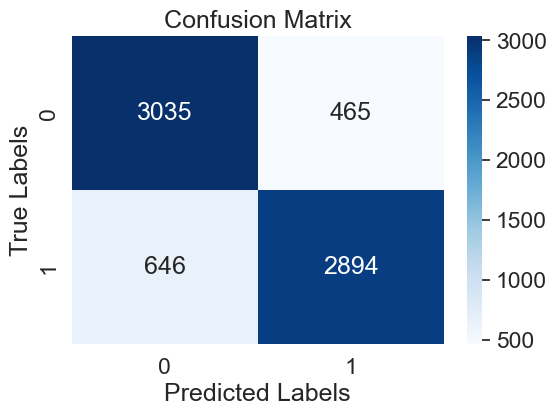

In [92]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Prediction Visualization

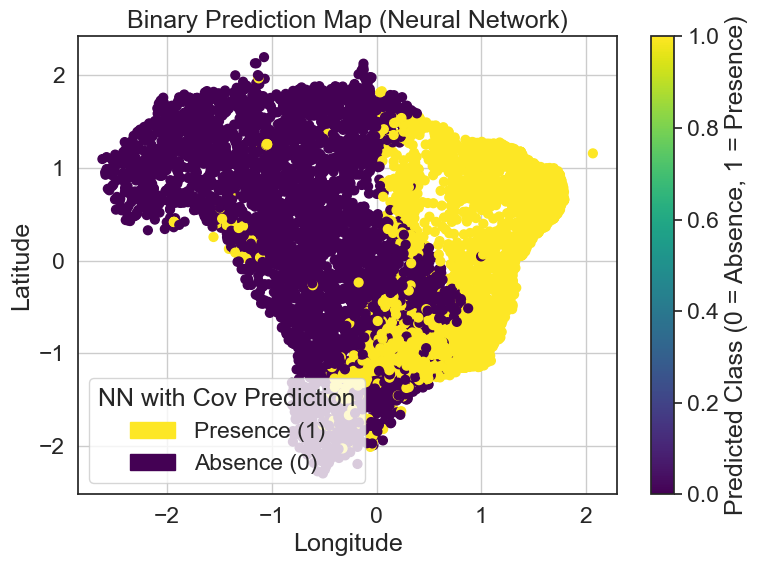

In [ ]:
binary_preds_np = binary_preds.cpu().numpy()  
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_test[:, 0],          
    X_test[:, 1],           
    c=binary_preds_np,      
    cmap="viridis",
    s=40
)
presence_patch = mpatches.Patch(color=plt.cm.viridis(1.0), label="Presence (1)")
absence_patch  = mpatches.Patch(color=plt.cm.viridis(0.0), label="Absence (0)")

plt.legend(handles=[presence_patch, absence_patch], title="NN with Cov Prediction")
plt.colorbar(label="Predicted Class (0 = Absence, 1 = Presence)")
plt.title("Binary Prediction Map (Neural Network)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()


# Block Testing - Experiment Extension

In [81]:
from sklearn.cluster import KMeans

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pseudo_df['cluster_id'] = kmeans.fit_predict(pseudo_df[['X', 'Y']])


In [82]:
print(pseudo_df.groupby('cluster_id')['presence'].value_counts())


cluster_id  presence
0           1           2007
            0            141
1           0           1339
            1            982
2           1           1800
            0            890
3           0           2630
            1            268
Name: count, dtype: int64


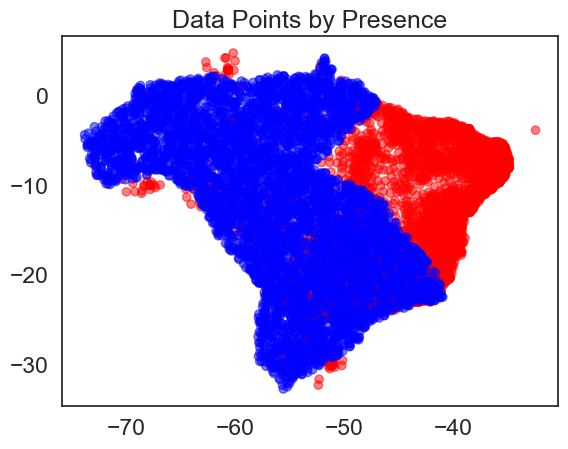

In [83]:
import matplotlib.pyplot as plt
plt.scatter(pseudo_df['X'], pseudo_df['Y'], c=pseudo_df['presence'], cmap='bwr', alpha=0.5)
plt.title('Data Points by Presence')
plt.show()

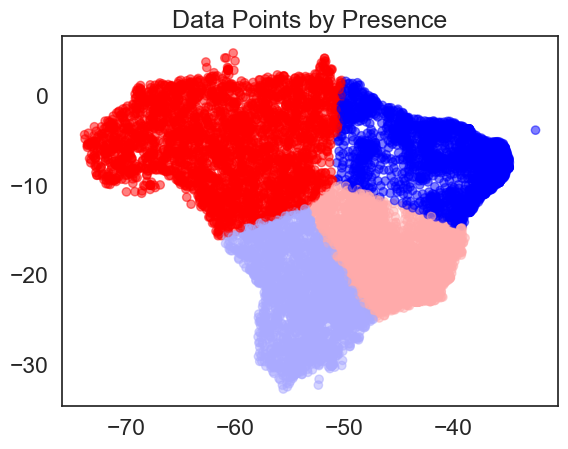

In [84]:
import matplotlib.pyplot as plt
plt.scatter(pseudo_df['X'], pseudo_df['Y'], c=pseudo_df['cluster_id'], cmap='bwr', alpha=0.5)
plt.title('Data Points by Presence')
plt.show()

In [85]:
train_clusters = [1, 3]
val_clusters = [0]
test_clusters = [2]

train_df = pseudo_df[pseudo_df['cluster_id'].isin(train_clusters)]
val_df = pseudo_df[pseudo_df['cluster_id'].isin(val_clusters)]
test_df = pseudo_df[pseudo_df['cluster_id'].isin(test_clusters)]


In [86]:
train_df = pseudo_df[pseudo_df['cluster_id'].isin(train_clusters)]
val_df = pseudo_df[pseudo_df['cluster_id'].isin(val_clusters)]
test_df = pseudo_df[pseudo_df['cluster_id'].isin(test_clusters)]

# Train Loop

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.no_grad():
    test_outputs = model(torch.tensor(X_test, dtype=torch.float32)).squeeze()
    test_probs = torch.sigmoid(test_outputs).cpu().numpy()
print("Mean probability:", np.mean(test_probs))
print("Min probability:", np.min(test_probs))
print("Max probability:", np.max(test_probs))
print("Sample probabilities:", test_probs[:20])


Mean probability: 0.64576066
Min probability: 0.36456448
Max probability: 0.75965065
Sample probabilities: [0.73724264 0.74436086 0.7451442  0.74124324 0.744395   0.7456659
 0.74833477 0.7493413  0.75072765 0.75159085 0.7528481  0.7536382
 0.7531011  0.7461265  0.75461143 0.75020885 0.75329953 0.74914044
 0.75463223 0.7550495 ]



Logistic Regression Baseline Report:
              precision    recall  f1-score   support

         0.0       0.57      0.43      0.49       890
         1.0       0.75      0.84      0.79      1800

    accuracy                           0.71      2690
   macro avg       0.66      0.64      0.64      2690
weighted avg       0.69      0.71      0.69      2690

Epoch 1 | Train Loss: 166.0618 | Val Loss: 0.9070 | Val Acc: 0.9586
Epoch 2 | Train Loss: 149.0317 | Val Loss: 0.5931 | Val Acc: 0.9530
Epoch 3 | Train Loss: 145.7939 | Val Loss: 1.0182 | Val Acc: 0.9595
Epoch 4 | Train Loss: 145.1492 | Val Loss: 1.3573 | Val Acc: 0.9344
Epoch 5 | Train Loss: 138.4008 | Val Loss: 1.4963 | Val Acc: 0.8571
Epoch 6 | Train Loss: 140.9523 | Val Loss: 1.6350 | Val Acc: 0.8538
Epoch 7 | Train Loss: 141.2403 | Val Loss: 2.0206 | Val Acc: 0.5545
Epoch 8 | Train Loss: 137.4846 | Val Loss: 2.6668 | Val Acc: 0.1979
Epoch 9 | Train Loss: 136.4406 | Val Loss: 3.1144 | Val Acc: 0.1345
Epoch 10 | Train Loss: 

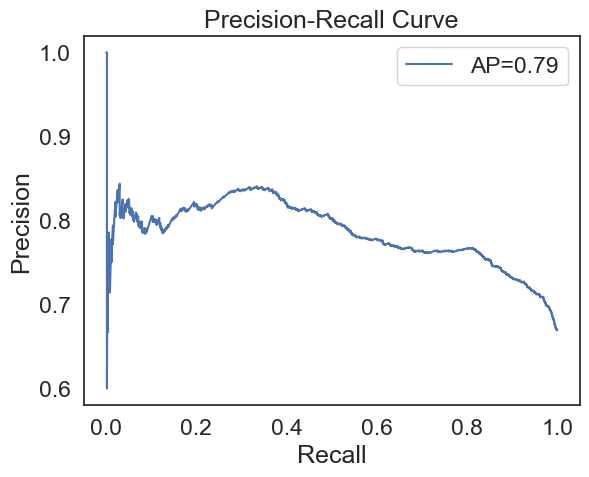


Neural Network Report:
              precision    recall  f1-score   support

         0.0       0.80      0.01      0.02       890
         1.0       0.67      1.00      0.80      1800

    accuracy                           0.67      2690
   macro avg       0.74      0.50      0.41      2690
weighted avg       0.71      0.67      0.54      2690



In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# === Prepare data ===
X_train_raw = train_df[['X', 'Y']].values
X_val_raw = val_df[['X', 'Y']].values
X_test_raw = test_df[['X', 'Y']].values

y_train = train_df['presence'].astype(np.float32).values
y_val = val_df['presence'].astype(np.float32).values
y_test = test_df['presence'].astype(np.float32).values

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw).astype(np.float32)
X_val = scaler.transform(X_val_raw).astype(np.float32)
X_test = scaler.transform(X_test_raw).astype(np.float32)

# Logistic regression baseline
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("\nLogistic Regression Baseline Report:")
print(classification_report(y_test, y_pred))

# Compute pos_weight
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
pos_weight_value = n_neg / n_pos
pos_weight = torch.tensor([pos_weight_value])

# Balanced sampler
class_counts = pd.Series(y_train).value_counts().to_dict()
sample_weights = [1.0 / class_counts[label] for label in y_train]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Datasets and loaders
train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler)

# neural net
class VanillaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.net(x)

model = VanillaNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Training loop
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

best_val_loss = float('inf')
best_model_state = None

for epoch in range(100):
    model.train()
    total_loss = 0

    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(x_batch).squeeze()
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor).squeeze()
        val_loss = loss_fn(val_outputs, y_val_tensor).item()
        val_probs = torch.sigmoid(val_outputs)
        val_preds = (val_probs > 0.5).int()
        val_acc = (val_preds == y_val_tensor.int()).float().mean().item()

    print(f"Epoch {epoch+1} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Track best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()

# Load best model
if best_model_state:
    model.load_state_dict(best_model_state)

# Final test evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(torch.tensor(X_test, dtype=torch.float32)).squeeze()
    test_probs = torch.sigmoid(test_outputs).cpu().numpy()

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, test_probs)
ap = average_precision_score(y_test, test_probs)

plt.plot(recall, precision, label=f'AP={ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Classification report
test_preds = (test_probs > 0.5).astype(int)
print("\nNeural Network Report:")
print(classification_report(y_test, test_preds))
